In [ ]:
# setup Colabs
!pip install brian2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00


In [2]:
from brian2 import *
#import brian2cuda
set_device("runtime")
#device.delete(force=True, code=True)
from models import StructuralPlasticityModel

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

#clear_cache('cython')

Starting simulation at t=0. s for a duration of 0.5 ks
1.9001 s (0%) simulated in 20s, estimated 1h 29m 35s remaining.
3.8001 s (0%) simulated in 40s, estimated 1h 28m 24s remaining.
5.6707 s (1%) simulated in 1m 0s, estimated 1h 28m 4s remaining.
7.4401 s (1%) simulated in 1m 20s, estimated 1h 28m 57s remaining.
9.2001 s (1%) simulated in 1m 41s, estimated 1h 29m 48s remaining.
10.9441 s (2%) simulated in 2m 1s, estimated 1h 30m 7s remaining.
12.6374 s (2%) simulated in 2m 21s, estimated 1h 30m 38s remaining.
14.3001 s (2%) simulated in 2m 41s, estimated 1h 31m 11s remaining.
16.0001 s (3%) simulated in 3m 1s, estimated 1h 31m 32s remaining.
17.7001 s (3%) simulated in 3m 22s, estimated 1h 31m 47s remaining.
19.4001 s (3%) simulated in 3m 42s, estimated 1h 32m 0s remaining.
21.0884 s (4%) simulated in 4m 2s, estimated 1h 31m 54s remaining.
22.7001 s (4%) simulated in 4m 23s, estimated 1h 32m 13s remaining.
24.3587 s (4%) simulated in 4m 43s, estimated 1h 32m 9s remaining.
25.9824 s (5

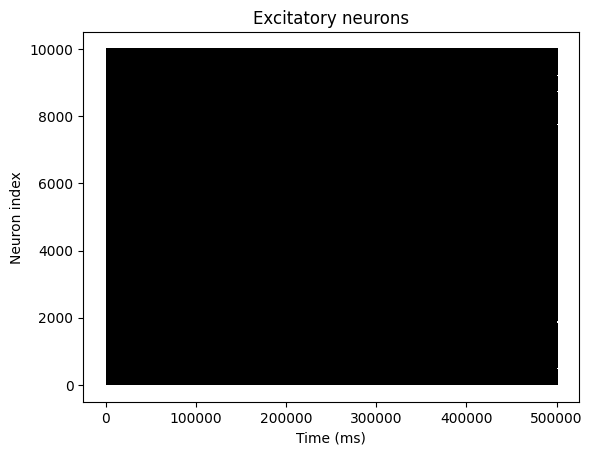

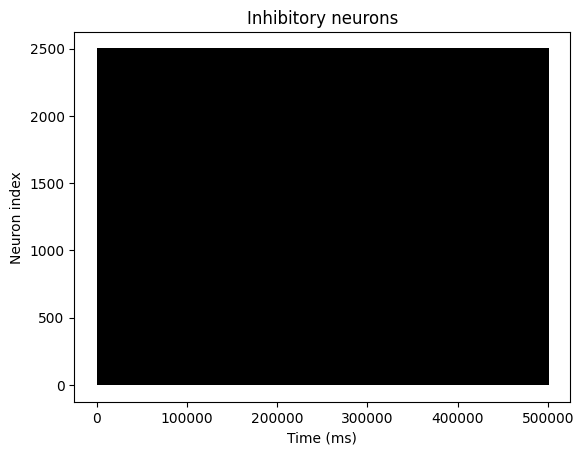

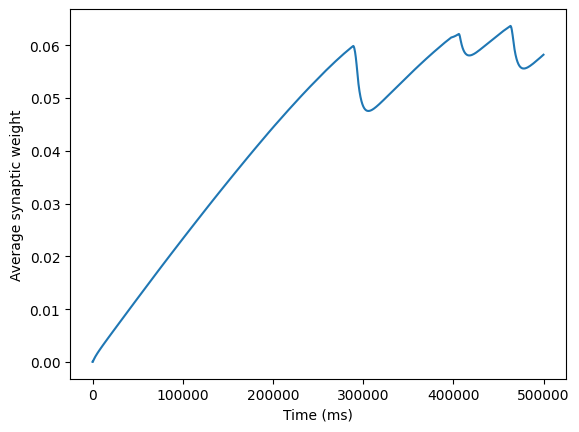

In [13]:
import logging
import itertools
logger = logging.getLogger('rewiring')
logger.setLevel(logging.DEBUG)
from models import StructuralPlasticityModel
model = StructuralPlasticityModel(
    order=2500, 
    V_th=20*mV, 
    delta_T_s=100*ms, 
    g=8, 
    tau_ca=5*second,
    enable_plasticity=True, 
    processes=None
)

mon = StateMonitor(model.E, ['phi', 'a', 'd'], dt=1*second, record=True)
#mon_s = StateMonitor(model.S_E_E, ['c'], dt=1*second, record=True)
#mon_r = PopulationRateMonitor(model.E)
model.network.add(mon)
    
model.run(500*second)

print(model.rewiring_time)


model.plot()
model.network.store(name='grown', filename='grown_1')

Starting simulation at t=0.5 ks for a duration of 150. s
1.3001 s (0%) simulated in 20s, estimated 38m 23s remaining.
2.6808 s (1%) simulated in 40s, estimated 36m 45s remaining.
4.0672 s (2%) simulated in 1m 0s, estimated 35m 58s remaining.
5.6239 s (3%) simulated in 1m 20s, estimated 34m 17s remaining.
7.2001 s (4%) simulated in 1m 40s, estimated 33m 10s remaining.
8.8001 s (5%) simulated in 2m 0s, estimated 32m 16s remaining.
10.4001 s (6%) simulated in 2m 21s, estimated 31m 35s remaining.
12.0001 s (8%) simulated in 2m 41s, estimated 30m 58s remaining.
13.6001 s (9%) simulated in 3m 1s, estimated 30m 25s remaining.
15.2001 s (10%) simulated in 3m 22s, estimated 29m 55s remaining.
16.8001 s (11%) simulated in 3m 42s, estimated 29m 26s remaining.
18.4001 s (12%) simulated in 4m 3s, estimated 28m 59s remaining.
20.0001 s (13%) simulated in 4m 23s, estimated 28m 33s remaining.
21.6001 s (14%) simulated in 4m 43s, estimated 28m 7s remaining.
23.2001 s (15%) simulated in 5m 4s, estimated

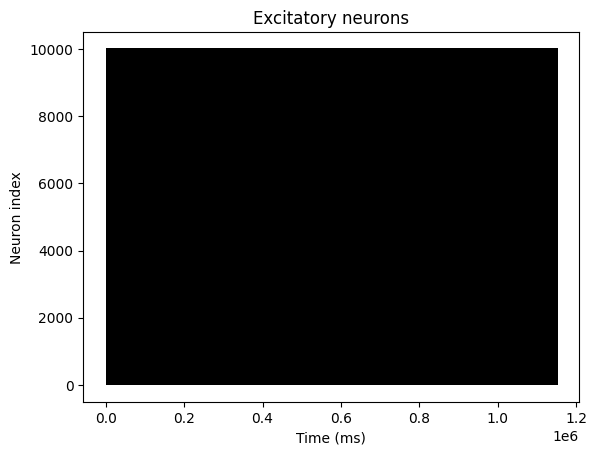

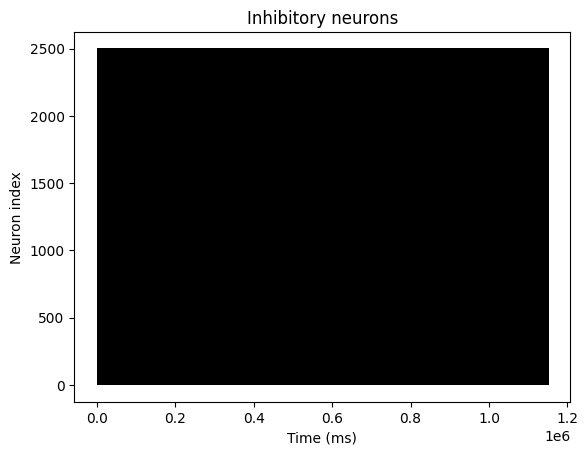

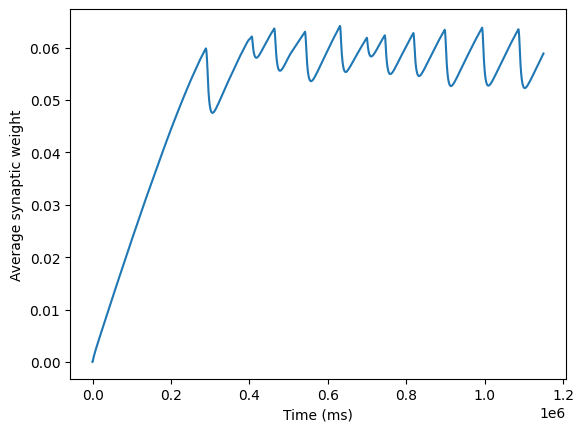

In [19]:
model.E.nu_ext[:1000] = 15.75
pop_mon = StateMonitor(model.E[:1000], ['phi', 'a', 'd'], dt=50*second, record=True)
model.network.add(pop_mon)
model.run(150*second)
model.E.nu_ext = 15
model.run(500*second)
model.plot()

In [20]:
np.savez('e_state.npz', t=mon.t/ms, phi=mon.phi, a=mon.a, d=mon.d)
np.savez('e_spikes.npz', t=model.spike_mon_E.t/ms, spikes=model.spike_mon_E.i)
np.savez('i_spikes.npz', t=model.spike_mon_I.t/ms, spikes=model.spike_mon_I.i)

In [21]:
e_state = np.load('e_state.npz')
e_spikes = np.load('e_spikes.npz')
i_spikes = np.load('i_spikes.npz')

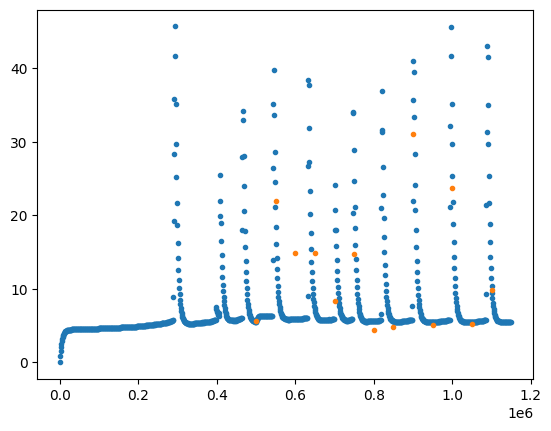

In [25]:
plt.plot(e_state['t'], mean(e_state['phi'], axis=0), '.')
plt.plot(pop_mon.t/ms, mean(pop_mon.phi, axis = 0), '.')
plt.show()
np.savez('pop_state', t=pop_mon.t/ms, phi=pop_mon.phi, a=pop_mon.a, d=pop_mon.d)

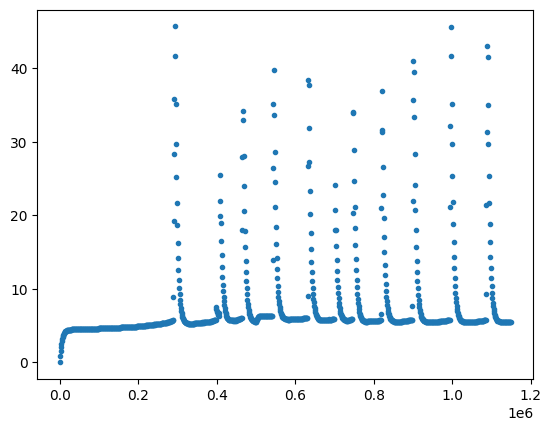

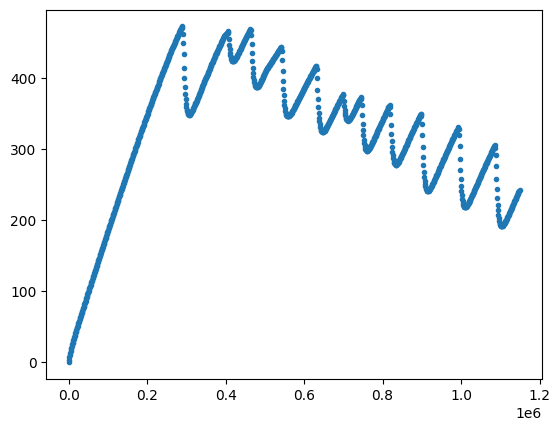

In [23]:
plt.plot(mon.t/ms, mean(mon.phi, axis=0), '.')
plt.show()
plt.plot(mon.t/ms, mean(mon.a, axis=0), '.')
plt.show()

In [15]:
model = StructuralPlasticityModel(order=1)
n_e = 10000 
c = np.random.randint(0, 3, size=(n_e, n_e))
a = np.random.randint(0, c.sum(axis=0), size=(n_e))

def new_disc(c, a):
    a = np.clip(a,0, np.sum(c, axis=1))
    gen = np.random.default_rng()
    for num, row in zip(a, c):
        x =  np.arange(0, n_e, dtype=int).repeat(row)   
        gen.shuffle(x)
        idx, cnt = np.unique(x[:num], return_counts=True)
        row[idx] -= cnt
    
target = c.sum(axis=0) - a
c_bak = c.copy()

tmp_time = time.time()
model._repeated_hypergeometric(c, a)
print("HyperTimer:", time.time() - tmp_time)

print("")

tmp_time = time.time()
new_disc(c_bak.T, a)
print("NewTimer:", time.time() - tmp_time)
print("SanityCheck::", np.all(c_bak.sum(axis=0) == target))
#x = np.arange(0, model.N_E, dtype=int)

S_I_I:  <S_I_I.N: 0>
S_I_E:  <S_I_E.N: 0>
S_E_I:  <S_E_I.N: 0>
HyperTimer: 10.623079776763916

NewTimer: 3.716747760772705
SanityCheck:: True


In [135]:
#model = StructuralPlasticityModel(order=2500)
n_e = 10000 
c = np.random.randint(0, 3, size=(n_e, n_e))
a = np.random.randint(0, c.sum(axis=1), size=(n_e))

target = c.sum(axis=1) - a
tmp_time = time.time()
gen = np.random.default_rng()
for num, row in zip(a, c):
    x =  np.arange(0, n_e, dtype=int).repeat(row)   
    idx, cnt = np.unique([np.random.choice(x, num, replace=False)], return_counts=True)
    row[idx] -= cnt
print("NewTimer:", time.time() - tmp_time)
print("SanityCheck::", np.all(c.sum(axis=1) == target))
#x = np.arange(0, model.N_E, dtype=int)

NewTimer: 3.3527934551239014
SanityCheck:: True


Trial:  0
Best Performance with  3  Threads at  0.13636469841003418 s


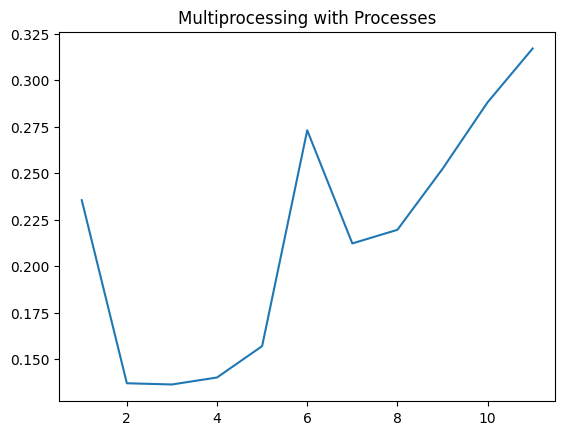

In [34]:
#from multiprocessing.pool import ThreadPool as Pool
from multiprocessing import Pool
import time

n_e = 1000 


def delete_connections(num, row):
    x =  np.arange(0, n_e, dtype=int).repeat(row)   
    gen.shuffle(x)
    idx, cnt = np.unique(x[:num], return_counts=True)
    row[idx] -= cnt
    
num_trials = 1 
num_threads = range(1, 12)
times = []
for i in range(0, num_trials):
    print("Trial: ", i)
    c = np.random.randint(0, 3, size=(n_e, n_e))
    a = np.random.randint(0, c.sum(axis=1), size=(n_e))

    for pool_size in num_threads:
	    c_bak = c.copy()
	    tmp_time = time.time()
	    pool = Pool(pool_size)
	
	    for num, row in zip(a, c_bak):
	        pool.apply_async(delete_connections, (num, row, ))
	    
	    pool.close()
	    pool.join()
	    times.append(time.time() - tmp_time)
	    #print("Time with ", pool_size, " Threads: ", times[-1])
	    
    
plt.title("Multiprocessing with Processes")
mean_times = np.array(times).reshape((num_trials, -1)).sum(axis=0)/num_trials
best = argmin(mean_times)
plot(num_threads, mean_times)
print("Best Performance with ",  best + 1, " Threads at ", mean_times[best], "s")

c.sum(axis=1)=array([ 9956,  9916,  9989, ..., 10102, 10050, 10080]), a=array([4657, 1921, 9622, ..., 3851, 8950,  396])
Time with  1  Threads:  4.497708320617676
Time with  2  Threads:  2.898247718811035
Time with  3  Threads:  2.25669002532959
Time with  4  Threads:  2.1725757122039795
Time with  5  Threads:  1.9636962413787842
Time with  6  Threads:  1.909329891204834
Time with  7  Threads:  1.7975828647613525
Time with  8  Threads:  1.669055700302124
Time with  9  Threads:  1.7214980125427246
Time with  10  Threads:  1.7235729694366455
Time with  11  Threads:  1.7839386463165283
Time with  12  Threads:  1.7565696239471436
Time with  13  Threads:  1.8070471286773682
Time with  14  Threads:  1.8688383102416992
Time with  15  Threads:  1.8412384986877441
Time with  16  Threads:  1.8540420532226562


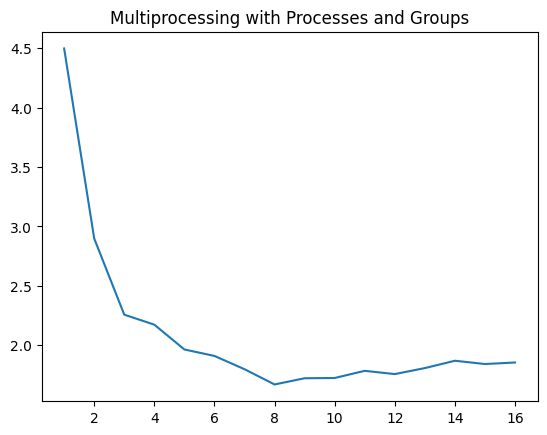

In [99]:
#from multiprocessing.pool import ThreadPool as Pool
from multiprocessing import Pool
import time

pool_size = 4

n_e = 10000 
c = np.random.randint(0, 3, size=(n_e, n_e))
a = np.random.randint(0, c.sum(axis=1), size=(n_e))

print(f'{c.sum(axis=1)=}, {a=}')

def delete_con(nums, rows):
    for num, row in zip(nums, rows):
        x =  np.arange(0, n_e, dtype=int).repeat(row)   
        gen.shuffle(x)
        idx, cnt = np.unique(x[:num], return_counts=True)
        row[idx] -= cnt
    
num_threads = range(1, 17)
times = []

for pool_size in num_threads:
    c_bak = c.copy()
    tmp_time = time.time()
    pool = Pool(pool_size)

    for nums, rows in zip(np.array_split(a, pool_size), np.array_split(c_bak, pool_size)):
        pool.apply_async(delete_con, (nums, rows, ))
    
    pool.close()
    pool.join()
    times.append(time.time() - tmp_time)
    print("Time with ", pool_size, " Threads: ", times[-1])
    
plt.title("Multiprocessing with Processes and Groups")
plot(num_threads, times)
